In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

import tensorflow as tf

In [31]:
c = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/COVID/images'
n = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/Normal/images'
p = 'D:/dataset/iwp2/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [32]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 5000) + os.listdir(p)

In [33]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [34]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [35]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [36]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [37]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [38]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 7968 validated image filenames belonging to 3 classes.


In [39]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 997 validated image filenames belonging to 3 classes.


In [40]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
#resnet_model=Sequential() 
resnet_model= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)



In [41]:

#headModel = resnet_model.output
for layer in resnet_model.layers:
    layer.trainable = False

headModel = resnet_model.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=resnet_model.input, outputs=headModel)


In [42]:
from tensorflow.keras.models import Sequential
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

In [43]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:

resnet_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_generator, validation_data=valid_generator, epochs=50)

Epoch 1/50
498/498 [==============================] - 219s 435ms/step - loss: 0.9739 - accuracy: 0.5131 - val_loss: 0.9562 - val_accuracy: 0.5888
Epoch 2/50
498/498 [==============================] - 75s 150ms/step - loss: 0.9458 - accuracy: 0.5353 - val_loss: 0.9162 - val_accuracy: 0.5797
Epoch 3/50
498/498 [==============================] - 75s 150ms/step - loss: 0.9311 - accuracy: 0.5458 - val_loss: 0.9024 - val_accuracy: 0.5958
Epoch 4/50
498/498 [==============================] - 71s 142ms/step - loss: 0.9175 - accuracy: 0.5640 - val_loss: 0.8817 - val_accuracy: 0.5657
Epoch 5/50
498/498 [==============================] - 72s 145ms/step - loss: 0.9053 - accuracy: 0.5640 - val_loss: 0.8896 - val_accuracy: 0.5356
Epoch 6/50
498/498 [==============================] - 65s 130ms/step - loss: 0.8919 - accuracy: 0.5712 - val_loss: 0.8677 - val_accuracy: 0.5978
Epoch 7/50
498/498 [==============================] - 64s 129ms/step - loss: 0.8876 - accuracy: 0.5659 - val_loss: 0.8527 - val_a

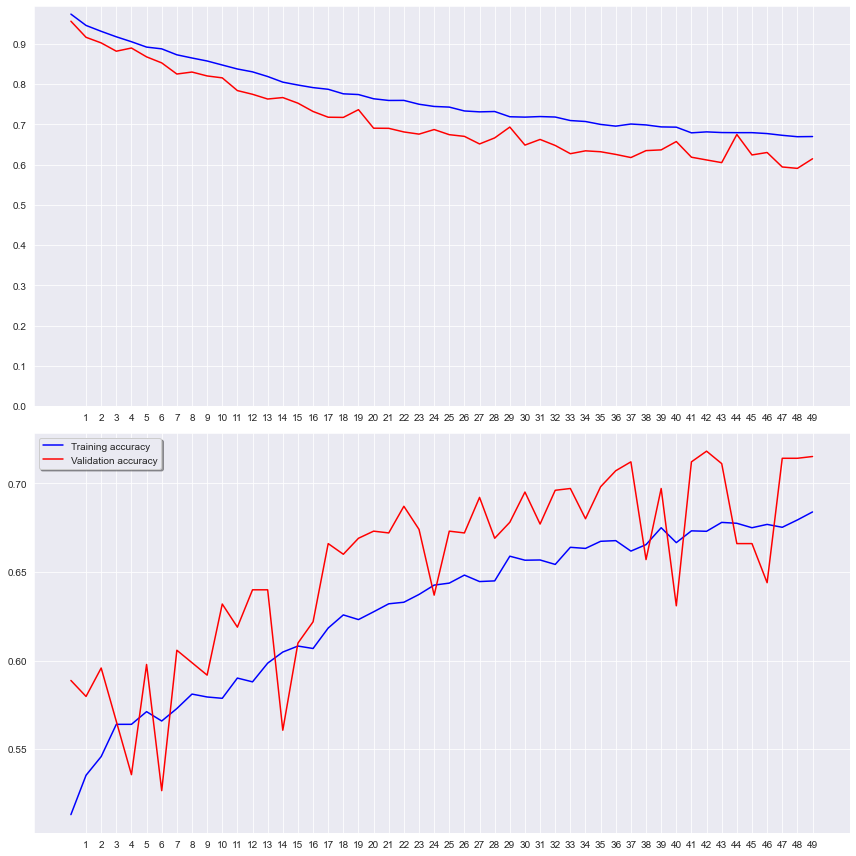

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()